<html>
<head>
	<title></title>
</head>
<body>
<h2 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ» Кафедра «РЗиАЭ»</h2>
<h2 style="text-align: center;line-height: 20%;">Лабораторная работа №4</h2>

<h3 style="text-align: center;line-height: 80%;"><em>Глубокое обучение для прогнозирования временного ряда.</em></h3>

<p style="text-align: right;line-height: 40%;">Выполнил: студент группы Э-13м-19</p>

<p style="text-align: right;line-height: 40%;">Энтентеев А.Р.</p>

<p style="text-align: right;line-height: 40%;">Проверил: Нухулов С.М.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2020</em></h3>
</body>
</html>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout,BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

### Подготовка данных

In [2]:
data = pd.read_csv("AEP_hourly.csv")

In [3]:
data = data.drop('Datetime',axis=1)
data.head()

,AEP_MW
0,13478.0
1,12865.0
2,12577.0
3,12517.0
4,12670.0


### Генератор для формирования обучающих пакетов

In [12]:
def generator(data, lookback, delay, min_index, max_index, 
                 shuffle = True, batch_size = 24, step = 2): 
    if max_index is None: 
        max_index = len(data)-delay-1 
    i = min_index + lookback 
    while 1: 
        if shuffle: 
                i = np.random.randint(min_index + lookback, max_index)
        if i + batch_size >= max_index:
            if shuffle: 
                i = np.random.randint(min_index + lookback, max_index)
            else: 
                i = min_index + lookback
               
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)             
        samples = np.zeros((len(rows), lookback // step, 
                           data.shape[-1]))
        targets = np.zeros((len(rows),)) 
        for j, row in enumerate(rows): 
            indices = range(rows[j] - lookback, rows[j], step) 
            samples[j] = data.iloc[indices] 
            targets[j] = data.iloc[rows[j] + delay] #[1] 
        yield samples, targets 

In [13]:
TrainGen = generator(data,48,1,0,63667,shuffle=True)
ValGen = generator(data,48,1,63668,84890,shuffle=True)
TestGen = generator(data,48,1,84891,121272,shuffle=True)

# Наивный алгоритм

(24, 24, 1)
Среднее отклонение =  864.875
Среднее абсолютное отклонение =  0.0662638835093408


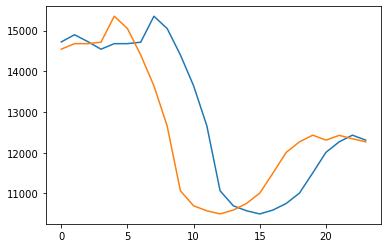

In [15]:
samples, targets = next(ValGen)
print(samples.shape)
prediction = samples[:,-1,0]
plt.plot(prediction)
plt.plot(range(0,24,1),targets[0:24])
ME = np.mean(np.abs(prediction[0:24] - targets[0:24]))
MAE = np.mean(np.abs(prediction[0:24] - targets[0:24])/prediction[0:24])
print("Среднее отклонение = ", ME)
print("Среднее абсолютное отклонение = ", MAE)


# Многослойный перцептрон

In [6]:
data = pd.read_csv("AEP_hourly.csv")

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
data = data.drop('Datetime',axis=1)
scaler.fit(data)
data = scaler.transform(data)


In [8]:
data = pd.DataFrame(data)
data

,0
0,0.241839
1,0.203798
2,0.185925
3,0.182202
4,0.191697
...,...
121268,0.714162
121269,0.708576
121270,0.697468
121271,0.672335


In [32]:
TrainGen = generator(data,48,1,0,63667,shuffle=True)
ValGen = generator(data,48,1,63668,84890,shuffle=True)
TestGen = generator(data,48,1,84891,121216,shuffle=True)

In [51]:
def createModel():
#     NB_CLASSES = y_train.shape[1]
    INPUT_SHAPE = (24,1)
    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    return model

In [52]:
def modelLearning(train_gen, val_gen, model, EPOCHS = 20):
    
    hist = model.fit(train_gen, steps_per_epoch = 300, epochs = EPOCHS,
                        verbose = 1, validation_data = val_gen, validation_steps = 200)
    return hist

In [53]:
def plotHistory(history):
    epochs = history.epoch
    plt.figure()
    plt.plot(epochs,history.history["mae"])
    plt.plot(epochs,history.history["val_mae"])
    plt.legend(["mae","val_mae"])
    plt.show()

In [128]:
def plotGraph(model):
    samples,targets = next(TestGen)
    prediction = model.predict(samples)
    plt.plot(targets)
    plt.plot(prediction)

In [54]:
model_1 = createModel()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 24)                0         
_________________________________________________________________
activation_15 (Activation)   (None, 24)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                800       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
activation_17 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                

In [55]:
model_1.compile(loss='mse',
              optimizer = 'rmsprop',
              metrics=["mae"])

In [56]:
history_1 = modelLearning(TrainGen,ValGen,model_1,20)

Epoch 1/20
300/300 [==============================] - 5s 17ms/step - loss: 0.0255 - mae: 0.1294 - val_loss: 0.0203 - val_mae: 0.1187
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.0178 - mae: 0.1071 - val_loss: 0.0174 - val_mae: 0.1110
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0129 - mae: 0.0890 - val_loss: 0.0120 - val_mae: 0.0887
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0119 - mae: 0.0859 - val_loss: 0.0073 - val_mae: 0.0659
Epoch 5/20
300/300 [==============================] - 4s 13ms/step - loss: 0.0110 - mae: 0.0825 - val_loss: 0.0125 - val_mae: 0.0909
Epoch 6/20
300/300 [==============================] - 4s 13ms/step - loss: 0.0107 - mae: 0.0810 - val_loss: 0.0069 - val_mae: 0.0643
Epoch 7/20
300/300 [==============================] - 4s 13ms/step - loss: 0.0104 - mae: 0.0794 - val_loss: 0.0066 - val_mae: 0.0628
Epoch 8/20
300/300 [==============================] - 4s 13ms/step - 

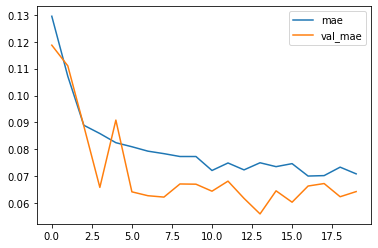

In [57]:
plotHistory(history_1)

In [127]:
model_1.evaluate(TestGen, steps = 150)

150/150 [==============================] - 1s 8ms/step - loss: 0.0075 - mae: 0.0646


[0.0074824863113462925, 0.0646476000547409]

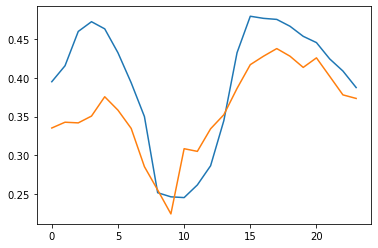

In [130]:
plotGraph(model_1)

# Вывод:
### Полученная модель получилась лучше, чем наивный подход и достигает среднего абсолютного отклонения 0,064 на тестовой выборке

# Сверточная сеть

In [78]:
def createCONVmodel():
    INPUT_SHAPE = (24,1)
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=INPUT_SHAPE)) 
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu')) 
    model.add(MaxPooling1D(pool_size=2,padding = 'valid'))
#     model.add(Conv1D(filters=128, kernel_size=4, activation='relu')) 
#     model.add(GlobalMaxPooling1D())
    model.add(Flatten()) 
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(Dense(1,activation = 'sigmoid')) 
    model.summary() 
    return model

In [79]:
model_2 = createCONVmodel()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 19, 32)            224       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 9, 32)             0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 6, 64)             8256      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                6176      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)              

In [80]:
model_2.compile(loss='mse',
              optimizer = 'rmsprop',
              metrics=["mae"])

In [81]:
history_2 = modelLearning(TrainGen,ValGen,model_2,20)

Epoch 1/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0262 - mae: 0.1309 - val_loss: 0.0131 - val_mae: 0.0914
Epoch 2/20
300/300 [==============================] - 4s 13ms/step - loss: 0.0149 - mae: 0.0965 - val_loss: 0.0154 - val_mae: 0.1032
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0139 - mae: 0.0933 - val_loss: 0.0087 - val_mae: 0.0728
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0122 - mae: 0.0863 - val_loss: 0.0083 - val_mae: 0.0703
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0108 - mae: 0.0805 - val_loss: 0.0062 - val_mae: 0.0611
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0100 - mae: 0.0775 - val_loss: 0.0074 - val_mae: 0.0675
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0100 - mae: 0.0790 - val_loss: 0.0088 - val_mae: 0.0729
Epoch 8/20
300/300 [==============================] - 4s 14ms/step - 

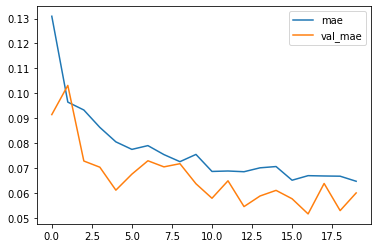

In [83]:
plotHistory(history_2)

In [84]:
model_2.evaluate(TestGen, steps = 500)

1513/1513 [==============================] - 16s 10ms/step - loss: 0.0072 - mae: 0.0671


[0.00719783129170537, 0.0670531839132309]

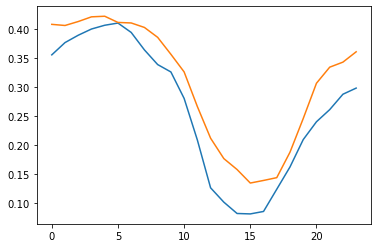

In [139]:
plotGraph(model_2)

# Вывод:
### Полученная модель получилась чуть хуже, чем многослойнвый перцептрон и достигает среднего абсолютного отклонения 0,67 на тестовой выборке

# Рекурентная сеть

In [93]:
def createRNNmodel():
    model = Sequential() 
    model.add(GRU(32, input_shape = (None, 1))) 
    model.add(Dense(1,activation = "sigmoid")) 
    model.summary() 
    return model

In [94]:
model_3 = createRNNmodel()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [95]:
model_3.compile(loss='mse',
              optimizer = 'rmsprop',
              metrics=["mae"])

In [96]:
history_3 = modelLearning(TrainGen,ValGen,model_3,20)

Epoch 1/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0246 - mae: 0.1259 - val_loss: 0.0173 - val_mae: 0.1051
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.0181 - mae: 0.1086 - val_loss: 0.0143 - val_mae: 0.0964
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0146 - mae: 0.0966 - val_loss: 0.0144 - val_mae: 0.0945
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0120 - mae: 0.0881 - val_loss: 0.0105 - val_mae: 0.0823
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0110 - mae: 0.0835 - val_loss: 0.0093 - val_mae: 0.0763
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0104 - mae: 0.0810 - val_loss: 0.0083 - val_mae: 0.0717
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - loss: 0.0102 - mae: 0.0803 - val_loss: 0.0108 - val_mae: 0.0809
Epoch 8/20
300/300 [==============================] - 4s 14ms/step - 

In [133]:
model_3.evaluate(TestGen, steps = 500)

500/500 [==============================] - 4s 8ms/step - loss: 0.0079 - mae: 0.0698


[0.007945071905851364, 0.06978649646043777]

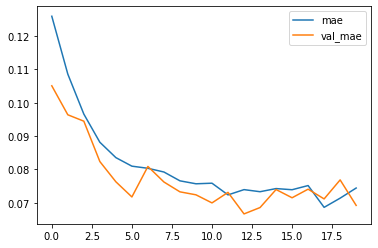

In [98]:
plotHistory(history_3)

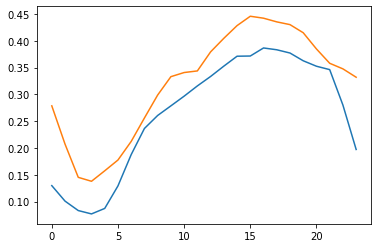

In [136]:
plotGraph(model_3)

In [108]:
def createRNNmodelplus():
    model = Sequential() 
    model.add(GRU(32, 
                  dropout = 0.1, 
                  recurrent_dropout = 0.4, 
                  input_shape = (None, 1),
                  return_sequences=True)) 
    model.add(GRU(64, dropout = 0.1, input_shape = (None, 1))) 
    model.add(Dense(1,activation = "sigmoid")) 
    model.summary() 
    return model

In [113]:
model_4 = createRNNmodelplus()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 32)          3360      
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 22,241
Trainable params: 22,241
Non-trainable params: 0
_________________________________________________________________


In [114]:
model_4.compile(loss='mse',
              optimizer = 'rmsprop',
              metrics=["mae"])

In [115]:
history_4 = modelLearning(TrainGen,ValGen,model_4,20)

Epoch 1/20
300/300 [==============================] - 32s 106ms/step - loss: 0.0216 - mae: 0.1173 - val_loss: 0.0174 - val_mae: 0.1055
Epoch 2/20
300/300 [==============================] - 32s 108ms/step - loss: 0.0169 - mae: 0.1039 - val_loss: 0.0104 - val_mae: 0.0830
Epoch 3/20
300/300 [==============================] - 32s 108ms/step - loss: 0.0152 - mae: 0.0964 - val_loss: 0.0099 - val_mae: 0.0784
Epoch 4/20
300/300 [==============================] - 33s 110ms/step - loss: 0.0129 - mae: 0.0887 - val_loss: 0.0080 - val_mae: 0.0711
Epoch 5/20
300/300 [==============================] - 33s 110ms/step - loss: 0.0119 - mae: 0.0847 - val_loss: 0.0091 - val_mae: 0.0754
Epoch 6/20
300/300 [==============================] - 33s 110ms/step - loss: 0.0111 - mae: 0.0822 - val_loss: 0.0105 - val_mae: 0.0814
Epoch 7/20
300/300 [==============================] - 33s 110ms/step - loss: 0.0119 - mae: 0.0851 - val_loss: 0.0079 - val_mae: 0.0691
Epoch 8/20
300/300 [==============================] - 3

In [116]:
model_4.evaluate(TestGen, steps = 500)

500/500 [==============================] - 6s 11ms/step - loss: 0.0072 - mae: 0.0670


[0.007208918686956167, 0.06699986010789871]

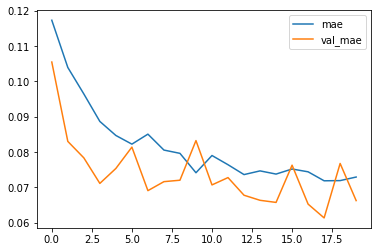

In [120]:
plotHistory(history_4)

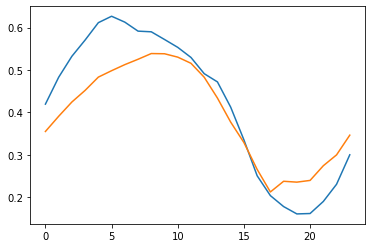

In [144]:
plotGraph(model_4)

# Вывод
### Усложненная модель рекурентной сети дает незначительно лучшее качество, чем однослойная рекурентная сеть, однако и это значение не превышает до обычного многослойного перцептрона
### В ходе работы были разработаны и исследованны модели для прогнозированния временного ряда, все построенные модели дают достаточно хорошее качество и прогнозируемое значение практически совпадает с реальным
### Стоит также отметить, что самое лучшее качество пргогнозирования показала модель многослойного перцептрона в виду особенности задачи прогнозирвоания случайоного временного ряда. Причина, по которой сверточаня и рекурентная нейронные сети оказались чуть хуже, заключается в отсутсвии каких-либо существенных закономерностях в данных, критичных для данных видов сетей.